In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping

2024-01-04 17:34:45.406635: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-04 17:34:45.410665: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-04 17:34:45.505419: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-04 17:34:45.505499: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-04 17:34:45.508655: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

*Chargement du Jeu de données* 

In [2]:
dataset = pd.read_csv("./MINI_10_LSTM_16notes.csv")
df = dataset.copy()

df_train = df.sample(frac=0.7, random_state=0)
df_valid = df.drop(df_train.index)

X_train = np.array([ eval(k) for k in df_train['X']])
X_test = np.array([ eval(k) for k in df_valid['X']])
y_train = np.array([ eval(k) for k in df_train['Y']])
y_test = np.array([ eval(k) for k in df_valid['Y']])

nombreDeNotesPrecedentes = len(X_train[0]) # nombre de notes précédentes à prendre en compte
formatNote = len(X_train[0][0]) # valeur de la note, durée, durée avant prochaine note

*Compilation des modèles*

20 neurones

2024-01-04 17:35:40.317825: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-04 17:35:40.320872: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/100
3415/3415 [==============================] - 64s 18ms/step - loss: 34080.4453 - mae: 66.6377 - val_loss: 40816.4688 - val_mae: 63.9489
Epoch 2/100
3415/3415 [==============================] - 61s 18ms/step - loss: 33121.5195 - mae: 65.2513 - val_loss: 42631.2344 - val_mae: 63.2052
Epoch 3/100
3415/3415 [==============================] - 62s 18ms/step - loss: 32710.6426 - mae: 63.8519 - val_loss: 39886.3867 - val_mae: 62.6048
Epoch 4/100
3415/3415 [==============================] - 62s 18ms/step - loss: 31831.1582 - mae: 62.6417 - val_loss: 39835.8438 - val_mae: 62.7647
Epoch 5/100
3415/3415 [==============================] - 60s 17ms/step - loss: 31504.6328 - mae: 62.5351 - val_loss: 39767.2031 - val_mae: 63.7741
Epoch 6/100
3415/3415 [==============================] - 59s 17ms/step - loss: 32301.0137 - mae: 62.5963 - val_loss: 39152.4414 - val_mae: 63.9274
Epoch 7/100
3415/3415 [==============================] - 58s 17ms/step - loss: 31892.0684 - mae: 62.6037 - val_loss: 4

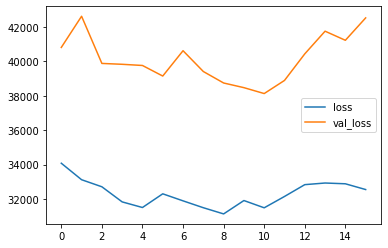

In [3]:
nombreDeNeurones = 20
batchNormalisation=False
dropout=False
# ------------------------------
nombreDeBatch = 32          # nombre de subdivisions du jeu de données
nombreDeEpoch = 100          # nombre de fois que l'on va parcourir le jeu de données
nombreDeEpochPatient = 5    # nombre d'epoch sans amélioration avant d'arrêter l'apprentissage

model = Sequential()
model.add( InputLayer(input_shape=(nombreDeNotesPrecedentes, formatNote)) )
model.add( LSTM(nombreDeNeurones, activation='relu') )
if dropout:
    model.add( Dropout(0.2) ) 
if batchNormalisation:
    model.add( BatchNormalization() )
model.add( Dense(formatNote) )
model.compile(optimizer='rmsprop', loss='mse',  metrics=['mae'])

early_stopping = EarlyStopping(
    min_delta=0.001, # quantité minimale considérable comme une amélioration
    patience=nombreDeEpochPatient,
    restore_best_weights=True,)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=nombreDeBatch,
    epochs=nombreDeEpoch,
    callbacks=[early_stopping],)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Erreur minimale atteinte : {}".format(history_df['val_loss'].min()))

Epoch 1/20
3415/3415 [==============================] - 11s 3ms/step - loss: 49886.3672 - mae: 80.9260 - val_loss: 53433.0391 - val_mae: 96.0051
Epoch 2/20
3415/3415 [==============================] - 11s 3ms/step - loss: 40721.5859 - mae: 71.6901 - val_loss: 49366.6250 - val_mae: 81.7408
Epoch 3/20
3415/3415 [==============================] - 11s 3ms/step - loss: 39109.0586 - mae: 70.6115 - val_loss: 46908.8203 - val_mae: 75.8890
Epoch 4/20
3415/3415 [==============================] - 11s 3ms/step - loss: 38530.9219 - mae: 69.8170 - val_loss: 46601.4648 - val_mae: 71.1126
Epoch 5/20
3415/3415 [==============================] - 11s 3ms/step - loss: 38286.1211 - mae: 69.5155 - val_loss: 46750.9453 - val_mae: 90.4600
Epoch 6/20
3415/3415 [==============================] - 11s 3ms/step - loss: 37639.1445 - mae: 67.4421 - val_loss: 54201.6836 - val_mae: 95.3140
Epoch 7/20
3415/3415 [==============================] - 11s 3ms/step - loss: 36846.0117 - mae: 65.9505 - val_loss: 46876.6211 - va

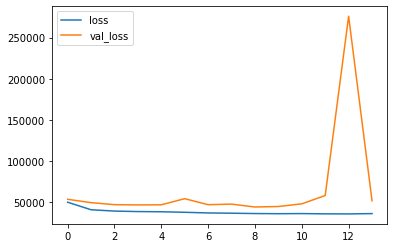

In [4]:
nombreDeNeurones = 20
batchNormalisation=True
dropout=False
# ------------------------------
nombreDeBatch = 32          # nombre de subdivisions du jeu de données
nombreDeEpoch = 20          # nombre de fois que l'on va parcourir le jeu de données
nombreDeEpochPatient = 5    # nombre d'epoch sans amélioration avant d'arrêter l'apprentissage

model = Sequential()
model.add( InputLayer(input_shape=(nombreDeNotesPrecedentes, formatNote)) )
model.add( LSTM(nombreDeNeurones, activation='relu') )
if dropout:
    model.add( Dropout(0.2) ) 
if batchNormalisation:
    model.add( BatchNormalization() )
model.add( Dense(formatNote) )
model.compile(optimizer='rmsprop', loss='mse',  metrics=['mae'])

early_stopping = EarlyStopping(
    min_delta=0.001, # quantité minimale considérable comme une amélioration
    patience=nombreDeEpochPatient,
    restore_best_weights=True,)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=nombreDeBatch,
    epochs=nombreDeEpoch,
    callbacks=[early_stopping],)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Erreur minimale atteinte : {}".format(history_df['val_loss'].min()))

Epoch 1/20
3415/3415 [==============================] - 10s 3ms/step - loss: 41099.4453 - mae: 76.3783 - val_loss: 43494.0078 - val_mae: 69.1861
Epoch 2/20
3415/3415 [==============================] - 11s 3ms/step - loss: 36026.2109 - mae: 69.9733 - val_loss: 43057.4727 - val_mae: 66.3063
Epoch 3/20
3415/3415 [==============================] - 10s 3ms/step - loss: 35581.9844 - mae: 70.0459 - val_loss: 43992.9336 - val_mae: 66.1817
Epoch 4/20
3415/3415 [==============================] - 10s 3ms/step - loss: 35925.1211 - mae: 68.7505 - val_loss: 43942.1992 - val_mae: 68.5400
Epoch 5/20
3415/3415 [==============================] - 10s 3ms/step - loss: 36260.1211 - mae: 70.6933 - val_loss: 43094.6680 - val_mae: 67.2145
Epoch 6/20
3415/3415 [==============================] - 11s 3ms/step - loss: 36280.5938 - mae: 69.9054 - val_loss: 43719.3633 - val_mae: 70.3224
Epoch 7/20
3415/3415 [==============================] - 10s 3ms/step - loss: 36198.6758 - mae: 68.8362 - val_loss: 44427.3633 - va

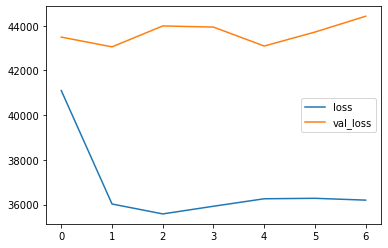

In [5]:
nombreDeNeurones = 20
batchNormalisation=False
dropout=True
# ------------------------------
nombreDeBatch = 32          # nombre de subdivisions du jeu de données
nombreDeEpoch = 20          # nombre de fois que l'on va parcourir le jeu de données
nombreDeEpochPatient = 5    # nombre d'epoch sans amélioration avant d'arrêter l'apprentissage

model = Sequential()
model.add( InputLayer(input_shape=(nombreDeNotesPrecedentes, formatNote)) )
model.add( LSTM(nombreDeNeurones, activation='relu') )
if dropout:
    model.add( Dropout(0.2) ) 
if batchNormalisation:
    model.add( BatchNormalization() )
model.add( Dense(formatNote) )
model.compile(optimizer='rmsprop', loss='mse',  metrics=['mae'])

early_stopping = EarlyStopping(
    min_delta=0.001, # quantité minimale considérable comme une amélioration
    patience=nombreDeEpochPatient,
    restore_best_weights=True,)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=nombreDeBatch,
    epochs=nombreDeEpoch,
    callbacks=[early_stopping],)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Erreur minimale atteinte : {}".format(history_df['val_loss'].min()))

Epoch 1/20
3415/3415 [==============================] - 10s 3ms/step - loss: 50602.8359 - mae: 79.8279 - val_loss: 52508.7148 - val_mae: 69.7179
Epoch 2/20
3415/3415 [==============================] - 12s 3ms/step - loss: 42087.5000 - mae: 72.9331 - val_loss: 50419.0586 - val_mae: 78.6837
Epoch 3/20
3415/3415 [==============================] - 12s 4ms/step - loss: 40815.6172 - mae: 71.3105 - val_loss: 47305.8008 - val_mae: 66.5693
Epoch 4/20
3415/3415 [==============================] - 11s 3ms/step - loss: 40273.4961 - mae: 70.9431 - val_loss: 46584.5156 - val_mae: 66.5624
Epoch 5/20
3415/3415 [==============================] - 12s 3ms/step - loss: 39689.6406 - mae: 70.4403 - val_loss: 46543.7031 - val_mae: 70.7462
Epoch 6/20
3415/3415 [==============================] - 12s 3ms/step - loss: 39474.6250 - mae: 70.2981 - val_loss: 44264.7617 - val_mae: 70.6632
Epoch 7/20
3415/3415 [==============================] - 11s 3ms/step - loss: 39651.9688 - mae: 70.6198 - val_loss: 44299.3945 - va

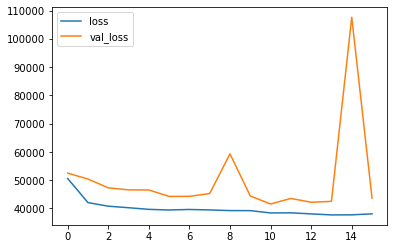

In [6]:
nombreDeNeurones = 20
batchNormalisation=True
dropout=True
# ------------------------------
nombreDeBatch = 32          # nombre de subdivisions du jeu de données
nombreDeEpoch = 20          # nombre de fois que l'on va parcourir le jeu de données
nombreDeEpochPatient = 5    # nombre d'epoch sans amélioration avant d'arrêter l'apprentissage

model = Sequential()
model.add( InputLayer(input_shape=(nombreDeNotesPrecedentes, formatNote)) )
model.add( LSTM(nombreDeNeurones, activation='relu') )
if dropout:
    model.add( Dropout(0.2) ) 
if batchNormalisation:
    model.add( BatchNormalization() )
model.add( Dense(formatNote) )
model.compile(optimizer='rmsprop', loss='mse',  metrics=['mae'])

early_stopping = EarlyStopping(
    min_delta=0.001, # quantité minimale considérable comme une amélioration
    patience=nombreDeEpochPatient,
    restore_best_weights=True,)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=nombreDeBatch,
    epochs=nombreDeEpoch,
    callbacks=[early_stopping],)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Erreur minimale atteinte : {}".format(history_df['val_loss'].min()))

100 neurones

Epoch 1/20
3415/3415 [==============================] - 17s 5ms/step - loss: 37758.5742 - mae: 71.4818 - val_loss: 52553.2266 - val_mae: 84.9589
Epoch 2/20
3415/3415 [==============================] - 16s 5ms/step - loss: 34310.6289 - mae: 66.8819 - val_loss: 44429.3516 - val_mae: 61.9224
Epoch 3/20
3415/3415 [==============================] - 17s 5ms/step - loss: 33292.0000 - mae: 65.7412 - val_loss: 42124.4609 - val_mae: 69.7307
Epoch 4/20
3415/3415 [==============================] - 17s 5ms/step - loss: 32284.4980 - mae: 64.0914 - val_loss: 40323.2930 - val_mae: 67.9849
Epoch 5/20
3415/3415 [==============================] - 16s 5ms/step - loss: 33441.0078 - mae: 66.2791 - val_loss: 40214.4883 - val_mae: 63.0533
Epoch 6/20
3415/3415 [==============================] - 16s 5ms/step - loss: 31370.6504 - mae: 62.7121 - val_loss: 40096.0078 - val_mae: 60.4182
Epoch 7/20
3415/3415 [==============================] - 16s 5ms/step - loss: 31973.4023 - mae: 62.5978 - val_loss: 39395.8203 - va

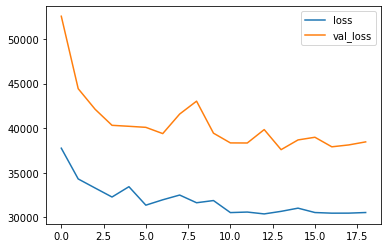

In [7]:
nombreDeNeurones = 100
batchNormalisation=False
dropout=False
# ------------------------------
nombreDeBatch = 32          # nombre de subdivisions du jeu de données
nombreDeEpoch = 20          # nombre de fois que l'on va parcourir le jeu de données
nombreDeEpochPatient = 5    # nombre d'epoch sans amélioration avant d'arrêter l'apprentissage

model = Sequential()
model.add( InputLayer(input_shape=(nombreDeNotesPrecedentes, formatNote)) )
model.add( LSTM(nombreDeNeurones, activation='relu') )
if dropout:
    model.add( Dropout(0.2) ) 
if batchNormalisation:
    model.add( BatchNormalization() )
model.add( Dense(formatNote) )
model.compile(optimizer='rmsprop', loss='mse',  metrics=['mae'])

early_stopping = EarlyStopping(
    min_delta=0.001, # quantité minimale considérable comme une amélioration
    patience=nombreDeEpochPatient,
    restore_best_weights=True,)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=nombreDeBatch,
    epochs=nombreDeEpoch,
    callbacks=[early_stopping],)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Erreur minimale atteinte : {}".format(history_df['val_loss'].min()))

Epoch 1/20
3415/3415 [==============================] - 19s 5ms/step - loss: 45652.9492 - mae: 76.0746 - val_loss: 57881.1523 - val_mae: 82.2509
Epoch 2/20
3415/3415 [==============================] - 18s 5ms/step - loss: 41234.1094 - mae: 71.3499 - val_loss: 51067.9336 - val_mae: 78.2789
Epoch 3/20
3415/3415 [==============================] - 18s 5ms/step - loss: 39814.2461 - mae: 69.8726 - val_loss: 59923.6445 - val_mae: 109.0904
Epoch 4/20
3415/3415 [==============================] - 18s 5ms/step - loss: 41160.6211 - mae: 71.8856 - val_loss: 100111.4609 - val_mae: 75.8158
Epoch 5/20
3415/3415 [==============================] - 18s 5ms/step - loss: 40253.5234 - mae: 71.2716 - val_loss: 443849.6562 - val_mae: 76.6610
Epoch 6/20
3415/3415 [==============================] - 18s 5ms/step - loss: 37924.9414 - mae: 67.4056 - val_loss: 54194.7188 - val_mae: 78.2299
Epoch 7/20
3415/3415 [==============================] - 17s 5ms/step - loss: 37344.9844 - mae: 66.3609 - val_loss: 57770.0742 -

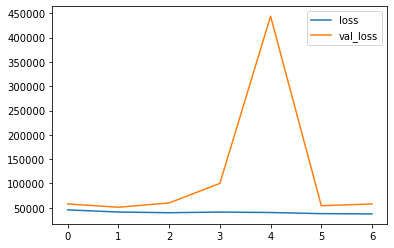

In [8]:
nombreDeNeurones = 100
batchNormalisation=True
dropout=False
# ------------------------------
nombreDeBatch = 32          # nombre de subdivisions du jeu de données
nombreDeEpoch = 20          # nombre de fois que l'on va parcourir le jeu de données
nombreDeEpochPatient = 5    # nombre d'epoch sans amélioration avant d'arrêter l'apprentissage

model = Sequential()
model.add( InputLayer(input_shape=(nombreDeNotesPrecedentes, formatNote)) )
model.add( LSTM(nombreDeNeurones, activation='relu') )
if dropout:
    model.add( Dropout(0.2) ) 
if batchNormalisation:
    model.add( BatchNormalization() )
model.add( Dense(formatNote) )
model.compile(optimizer='rmsprop', loss='mse',  metrics=['mae'])

early_stopping = EarlyStopping(
    min_delta=0.001, # quantité minimale considérable comme une amélioration
    patience=nombreDeEpochPatient,
    restore_best_weights=True,)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=nombreDeBatch,
    epochs=nombreDeEpoch,
    callbacks=[early_stopping],)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Erreur minimale atteinte : {}".format(history_df['val_loss'].min()))

Epoch 1/20
3415/3415 [==============================] - 18s 5ms/step - loss: 36492.2148 - mae: 71.0799 - val_loss: 41515.8477 - val_mae: 69.4988
Epoch 2/20
3415/3415 [==============================] - 18s 5ms/step - loss: 34983.2188 - mae: 68.8336 - val_loss: 39991.2109 - val_mae: 66.3702
Epoch 3/20
3415/3415 [==============================] - 18s 5ms/step - loss: 35596.8438 - mae: 70.9179 - val_loss: 42496.7266 - val_mae: 69.3447
Epoch 4/20
3415/3415 [==============================] - 17s 5ms/step - loss: 36420.5156 - mae: 72.0658 - val_loss: 43068.0938 - val_mae: 69.5152
Epoch 5/20
3415/3415 [==============================] - 17s 5ms/step - loss: 35533.0391 - mae: 69.7346 - val_loss: 42597.8320 - val_mae: 68.3246
Epoch 6/20
3415/3415 [==============================] - 18s 5ms/step - loss: 34818.5117 - mae: 68.2035 - val_loss: 41661.0859 - val_mae: 65.2536
Epoch 7/20
3415/3415 [==============================] - 18s 5ms/step - loss: 34346.0742 - mae: 68.2770 - val_loss: 41780.0039 - va

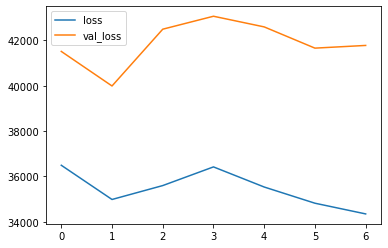

In [9]:
nombreDeNeurones = 100
batchNormalisation=False
dropout=True
# ------------------------------
nombreDeBatch = 32          # nombre de subdivisions du jeu de données
nombreDeEpoch = 20          # nombre de fois que l'on va parcourir le jeu de données
nombreDeEpochPatient = 5    # nombre d'epoch sans amélioration avant d'arrêter l'apprentissage

model = Sequential()
model.add( InputLayer(input_shape=(nombreDeNotesPrecedentes, formatNote)) )
model.add( LSTM(nombreDeNeurones, activation='relu') )
if dropout:
    model.add( Dropout(0.2) ) 
if batchNormalisation:
    model.add( BatchNormalization() )
model.add( Dense(formatNote) )
model.compile(optimizer='rmsprop', loss='mse',  metrics=['mae'])

early_stopping = EarlyStopping(
    min_delta=0.001, # quantité minimale considérable comme une amélioration
    patience=nombreDeEpochPatient,
    restore_best_weights=True,)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=nombreDeBatch,
    epochs=nombreDeEpoch,
    callbacks=[early_stopping],)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Erreur minimale atteinte : {}".format(history_df['val_loss'].min()))

Epoch 1/20
3415/3415 [==============================] - 18s 5ms/step - loss: 46829.2969 - mae: 76.6464 - val_loss: 54254.9141 - val_mae: 75.3532
Epoch 2/20
3415/3415 [==============================] - 16s 5ms/step - loss: 42575.6914 - mae: 72.8143 - val_loss: 51871.6211 - val_mae: 68.8580
Epoch 3/20
3415/3415 [==============================] - 17s 5ms/step - loss: 42064.0234 - mae: 72.5721 - val_loss: 1307378.8750 - val_mae: 114.2926
Epoch 4/20
3415/3415 [==============================] - 17s 5ms/step - loss: 42260.6055 - mae: 73.2516 - val_loss: 51488.2188 - val_mae: 71.6846
Epoch 5/20
3415/3415 [==============================] - 18s 5ms/step - loss: 41311.8789 - mae: 72.6917 - val_loss: 53339.9102 - val_mae: 71.4982
Epoch 6/20
3415/3415 [==============================] - 20s 6ms/step - loss: 41386.5234 - mae: 72.6139 - val_loss: 50323.2695 - val_mae: 71.7295
Epoch 7/20
3415/3415 [==============================] - 18s 5ms/step - loss: 40933.6094 - mae: 72.1212 - val_loss: 57574.1680 -

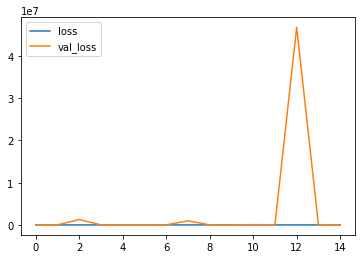

In [10]:
nombreDeNeurones = 100
batchNormalisation=True
dropout=True
# ------------------------------
nombreDeBatch = 32          # nombre de subdivisions du jeu de données
nombreDeEpoch = 20          # nombre de fois que l'on va parcourir le jeu de données
nombreDeEpochPatient = 5    # nombre d'epoch sans amélioration avant d'arrêter l'apprentissage

model = Sequential()
model.add( InputLayer(input_shape=(nombreDeNotesPrecedentes, formatNote)) )
model.add( LSTM(nombreDeNeurones, activation='relu') )
if dropout:
    model.add( Dropout(0.2) ) 
if batchNormalisation:
    model.add( BatchNormalization() )
model.add( Dense(formatNote) )
model.compile(optimizer='rmsprop', loss='mse',  metrics=['mae'])

early_stopping = EarlyStopping(
    min_delta=0.001, # quantité minimale considérable comme une amélioration
    patience=nombreDeEpochPatient,
    restore_best_weights=True,)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=nombreDeBatch,
    epochs=nombreDeEpoch,
    callbacks=[early_stopping],)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Erreur minimale atteinte : {}".format(history_df['val_loss'].min()))